## GPU Configuration and Imports <a class="anchor" id="GPU-Configuration-and-Imports"></a>

In [1]:
import os # Configure which GPU 
gpu_num = 0 # Use "" to use the CPU
os.environ["CUDA_VISIBLE_DEVICES"] = f"{gpu_num}"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Colab does currently not support the latest version of ipython.
# Thus, the preview does not work in Colab. However, whenever possible we 
# strongly recommend to use the scene preview mode.
try: # detect if the notebook runs in Colab
    import google.colab
    colab_compat = True # deactivate preview
except:
    colab_compat = False
resolution = [480,320] # increase for higher quality of renderings

# Allows to exit cell execution in Jupyter
class ExitCell(Exception):
    def _render_traceback_(self):
        pass

# Import Sionna
try:
    import sionna
except ImportError as e:
    # Install Sionna if package is not already installed
    import os
    os.system("pip install sionna")
    import sionna

# Configure the notebook to use only a single GPU and allocate only as much memory as needed
# For more details, see https://www.tensorflow.org/guide/gpu
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
print(gpus)
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e) 
# Avoid warnings from TensorFlow
tf.get_logger().setLevel('ERROR')

tf.random.set_seed(1) # Set global random seed for reproducibility
            
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import sys
    
from sionna.channel import cir_to_time_channel
from sionna.rt import load_scene, PlanarArray, Transmitter, Receiver, RadioMaterial, Camera, LambertianPattern, DirectivePattern, BackscatteringPattern
from sionna.rt.utils import r_hat
from sionna.constants import PI, SPEED_OF_LIGHT
from sionna.utils import expand_to_rank

from PIL import Image
from IPython.display import display
import time
import csv
# from ipywidgets import IntProgress
import ipywidgets as widgets
import random
import gc

[]


In [2]:
# scene_path=sionna.rt.scene.simple_street_canyon
# scene_path="my_scene/nycu_test/nycu_test.xml"
scene_path="my_scene/nycu_test_v3_paper_with_sun/nycu_test_v3_paper_with_sun.xml"
# scene_path="my_scene/hokudai/hokudai.xml"
# scene_path="my_scene/testv2/testv2.xml"
scene = load_scene(scene_path)

# for i, obj in enumerate(scene.objects.values()):
#     print(f"{obj.name} : {obj.radio_material.name}")

print(f"size of the scene: {scene.size}")
scene.preview()

size of the scene: [1202.5404  1200.        70.25106]


Renderer(camera=PerspectiveCamera(aspect=1.31, children=(DirectionalLight(intensity=0.25, position=(0.0, 0.0, …

In [3]:
scene.frequency = 2.65e9
frequency = scene.frequency
new_material = RadioMaterial(f"my_material_{frequency}",
                            relative_permittivity=5.24,
                            conductivity=0.0462*(frequency/1e9)**0.7822,
                            scattering_pattern=LambertianPattern())
for i, obj in enumerate(scene.objects.values()):
    scene.get(obj.name).radio_material=new_material
    # print(f"{obj.name} : {obj.radio_material.name}")
    # print(scene.get(obj.name).radio_material.conductivity)
    


used time of computing paths: 0.9769046320000143s
received_power: -80.60583114624023
(<tf.Tensor: shape=(1, 1, 1, 1, 1, 17, 1), dtype=complex64, numpy=
array([[[[[[[ 8.7431094e-05+0.0000000e+00j],
            [-2.5376346e-06+2.5686353e-07j],
            [-2.7427392e-05-1.7156255e-05j],
            [-2.8813425e-08+1.9258129e-08j],
            [-5.8538934e-09+3.3897393e-08j],
            [ 2.5887985e-09+2.4648370e-09j],
            [ 4.7044566e-08-1.1538798e-08j],
            [ 5.1821769e-10-5.4101488e-09j],
            [-1.5741694e-09-6.3057098e-10j],
            [-1.1052697e-08+3.8965073e-08j],
            [-4.1530626e-08+8.8604466e-09j],
            [-1.8971429e-09+2.6028817e-09j],
            [ 2.6867912e-09-2.2289350e-09j],
            [-1.4279607e-07+4.3287815e-07j],
            [ 1.2643291e-07-1.8738673e-07j],
            [-5.3020432e-08-5.1922640e-08j],
            [ 3.2079669e-08+6.1403563e-07j]]]]]]], dtype=complex64)>, <tf.Tensor: shape=(1, 1, 1, 17), dtype=float32, numpy=
arr

Renderer(camera=PerspectiveCamera(aspect=1.31, children=(DirectionalLight(intensity=0.25, position=(0.0, 0.0, …

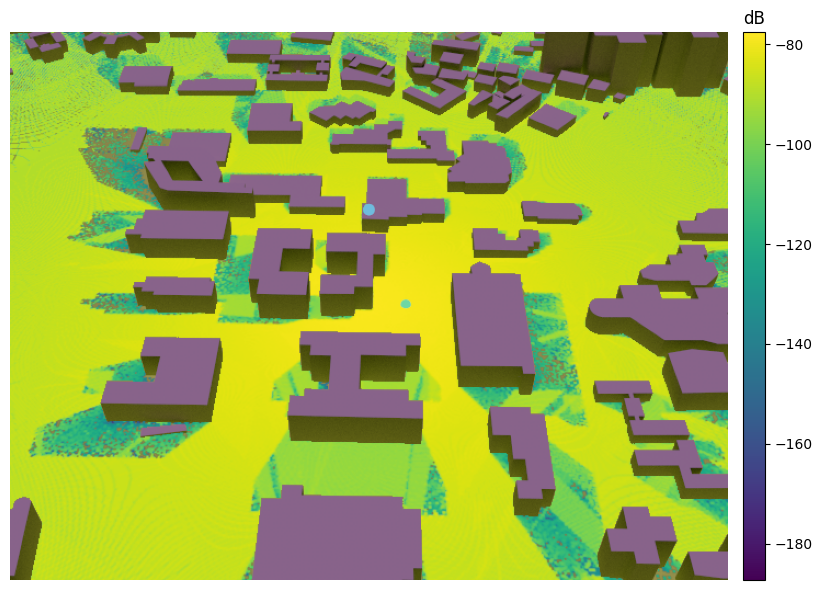

In [4]:
# # # scene_path="my_scene/nycu_test/nycu_test.xml"
# # # scene = load_scene(scene_path)
scene.remove("my_cam")
scene.remove("tx01")
scene.remove("tx02")
scene.remove("rx01")
scene.remove("rx02")
scene.remove("rx03")
# # # Set the carrier frequency

# wavelength = scene.wavelength



scene.add(Camera("my_cam", position=[0, -500, 500], look_at=[0,0,0]))
# # # Configure the transmitter and receiver arrays
scene.tx_array = PlanarArray(num_rows=1,
                             num_cols=1,
                             vertical_spacing=0.5,
                             horizontal_spacing=0.5,
                             pattern="iso",
                             polarization="V")

scene.rx_array = scene.tx_array


tx_position1=np.array([0, 0, 100])
tx_position2=np.array([0, 0, 200])
# scene.add(Transmitter(name="tx02", position=tx_position2))
scene.add(Transmitter(name="tx01", position=tx_position1))

rx_position1=[30, 0, 1.5]
rx_position2=[30, 0, 50]
rx_position3=[30, 0, 100]

scene.add(Receiver(name="rx01", position=rx_position1))
# scene.add(Receiver(name="rx02", position=rx_position2))
# scene.add(Receiver(name="rx03", position=rx_position3))



t_start = time.perf_counter()
paths = scene.compute_paths(los=True, reflection=True, scattering=False, diffraction=True, scat_keep_prob=1, edge_diffraction=False)
# paths = scene.compute_paths(los=False, reflection=False, scattering=False, diffraction=True, scat_keep_prob=0.001)
t_end = time.perf_counter()
print(f"used time of computing paths: {t_end-t_start}s")
received_power=10*np.log10(tf.reduce_sum(tf.abs(paths.a)**2))
print(f"received_power: {received_power}")
# Open 3D preview (only works in Jupyter notebook)
t_start = time.perf_counter()
cm = scene.coverage_map(max_depth=5,
                        diffraction=True, # Disable to see the effects of diffraction
                        cm_cell_size=(1., 1.), # Grid size of coverage map cells in m
                        combining_vec=None,
                        precoding_vec=None,
                        num_samples=int(2e6)) # Reduce if your hardware does not have enough memory
# # t_end = time.perf_counter()
# # print(f"used time of coverage map: {t_end-t_start}s")
render_to_file=False
# # scene.render("my_cam",num_samples=512 , paths=paths , coverage_map=cm);
# # scene.render(camera="my_cam",num_samples=512 , coverage_map=cm);
if render_to_file:
    filename="nycu_test.png"
    scene.render_to_file(camera="my_cam", # Also try camera="preview"
                         filename=filename,
                         # paths=paths,
                         coverage_map=cm
                         )
    img = Image.open(filename)
    display(img)
print(paths.cir())
# scene.preview()
# # # print(f"There are {tf.size(paths.a).numpy()} paths")
# # # print(paths.a)
scene.render(camera="my_cam", coverage_map=cm, num_samples=512)
# scene.preview(coverage_map=cm, paths=paths)
scene.preview(paths=paths)
# # # print(f"power:{10*np.log10(tf.reduce_sum(tf.abs(paths.a)**2))}")